In [80]:
import docplex
import pandas as pd
import numpy as np
from docplex.mp.model import Model
import matplotlib.pyplot as plt

In [21]:
data = pd.read_excel('Input_clsp.xlsx')
data

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 37,Unnamed: 38,Unnamed: 39,Unnamed: 40,Unnamed: 41,Unnamed: 42,Unnamed: 43,Unnamed: 44,Unnamed: 45,Unnamed: 46
0,NaN,Products,Setup Costs,Holding Costs,Production Time,NaN,Demand,1.0,2.0,3.0,...,31.0,32.0,33.0,34.0,35.0,36.0,37.0,38.0,39.0,40.0
1,NaN,A,10000,4,0.6,NaN,A,0.0,0.0,0.0,...,750.0,0.0,0.0,254.0,0.0,0.0,0.0,0.0,0.0,0.0
2,NaN,B,15000,3,0.8,NaN,B,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0
3,NaN,C,16000,4,1,NaN,C,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,550.0,0.0,0.0
4,NaN,D,12000,2,1.6,NaN,D,0.0,0.0,0.0,...,880.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,NaN,E,20000,1,0.4,NaN,E,0.0,0.0,0.0,...,0.0,0.0,119.0,0.0,116.0,0.0,0.0,842.0,0.0,804.0
6,NaN,F,10000,3,1.2,NaN,F,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,81.0
7,NaN,G,12000,2,1,NaN,G,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,974.0,147.0,0.0,0.0
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [74]:
products = list(data.iloc[1:8,1])
periods = np.arange(1,41)

input_data = data.iloc[1:8,2:5]
input_data.columns = ['Setup Costs', 'Holding Costs', 'Production Time']
input_data.index = products

demand = data.iloc[1:8, 7:47]
demand.columns = periods
demand.index = products

max_capacity = data.iloc[10,2]

L0 = 0
bigM = 1000000

In [2]:
model = Model(name='clsp', log_outout=False)

In [47]:
X = model.continuous_var_matrix(products, periods, name='production')
L = model.continuous_var_matrix(products, periods, name='inventory')
G = model.binary_var_matrix(products, periods, name='setup')

In [76]:
# inventory balance equation
model.add_constraints((L[p,t-1] + X[p,t] - demand.loc[p,t] == L[p,t]) for t in periods[1:] for p in products) # skip the first entry in the list of periods
model.add_constraints((L0 + X[p,1] - demand.loc[p,1] == L[p,1]) for p in products)

# setups
model.add_constraints((X[p,t] <= bigM * G[p,t]) for t in periods for p in products)

# capacity may not be exceeded
model.add_constraints(model.sum(input_data.loc[p,'Production Time'] * X[p,t] for p in products) <= max_capacity for t in periods)

[docplex.mp.LinearConstraint[](0.600production_A_1+0.800production_B_1+production_C_1+1.600production_D_1+0.400production_E_1+1.200production_F_1+production_G_1,LE,1000),
 docplex.mp.LinearConstraint[](0.600production_A_2+0.800production_B_2+production_C_2+1.600production_D_2+0.400production_E_2+1.200production_F_2+production_G_2,LE,1000),
 docplex.mp.LinearConstraint[](0.600production_A_3+0.800production_B_3+production_C_3+1.600production_D_3+0.400production_E_3+1.200production_F_3+production_G_3,LE,1000),
 docplex.mp.LinearConstraint[](0.600production_A_4+0.800production_B_4+production_C_4+1.600production_D_4+0.400production_E_4+1.200production_F_4+production_G_4,LE,1000),
 docplex.mp.LinearConstraint[](0.600production_A_5+0.800production_B_5+production_C_5+1.600production_D_5+0.400production_E_5+1.200production_F_5+production_G_5,LE,1000),
 docplex.mp.LinearConstraint[](0.600production_A_6+0.800production_B_6+production_C_6+1.600production_D_6+0.400production_E_6+1.200production_F_6

In [77]:
Z = model.sum(input_data.loc[p, 'Holding Costs'] * L[p,t] + input_data.loc[p, 'Setup Costs'] * G[p,t] for t in periods for p in products)
model.minimize(Z)

In [78]:
model.solve()
print(model.solve_details)

status  = integer optimal, tolerance
time    = 2.9538 s.
problem = MILP
gap     = 0.00994007%



In [122]:
print(f'The objective value of the model is {model.objective_value}')

The objective value of the model is 604235.6


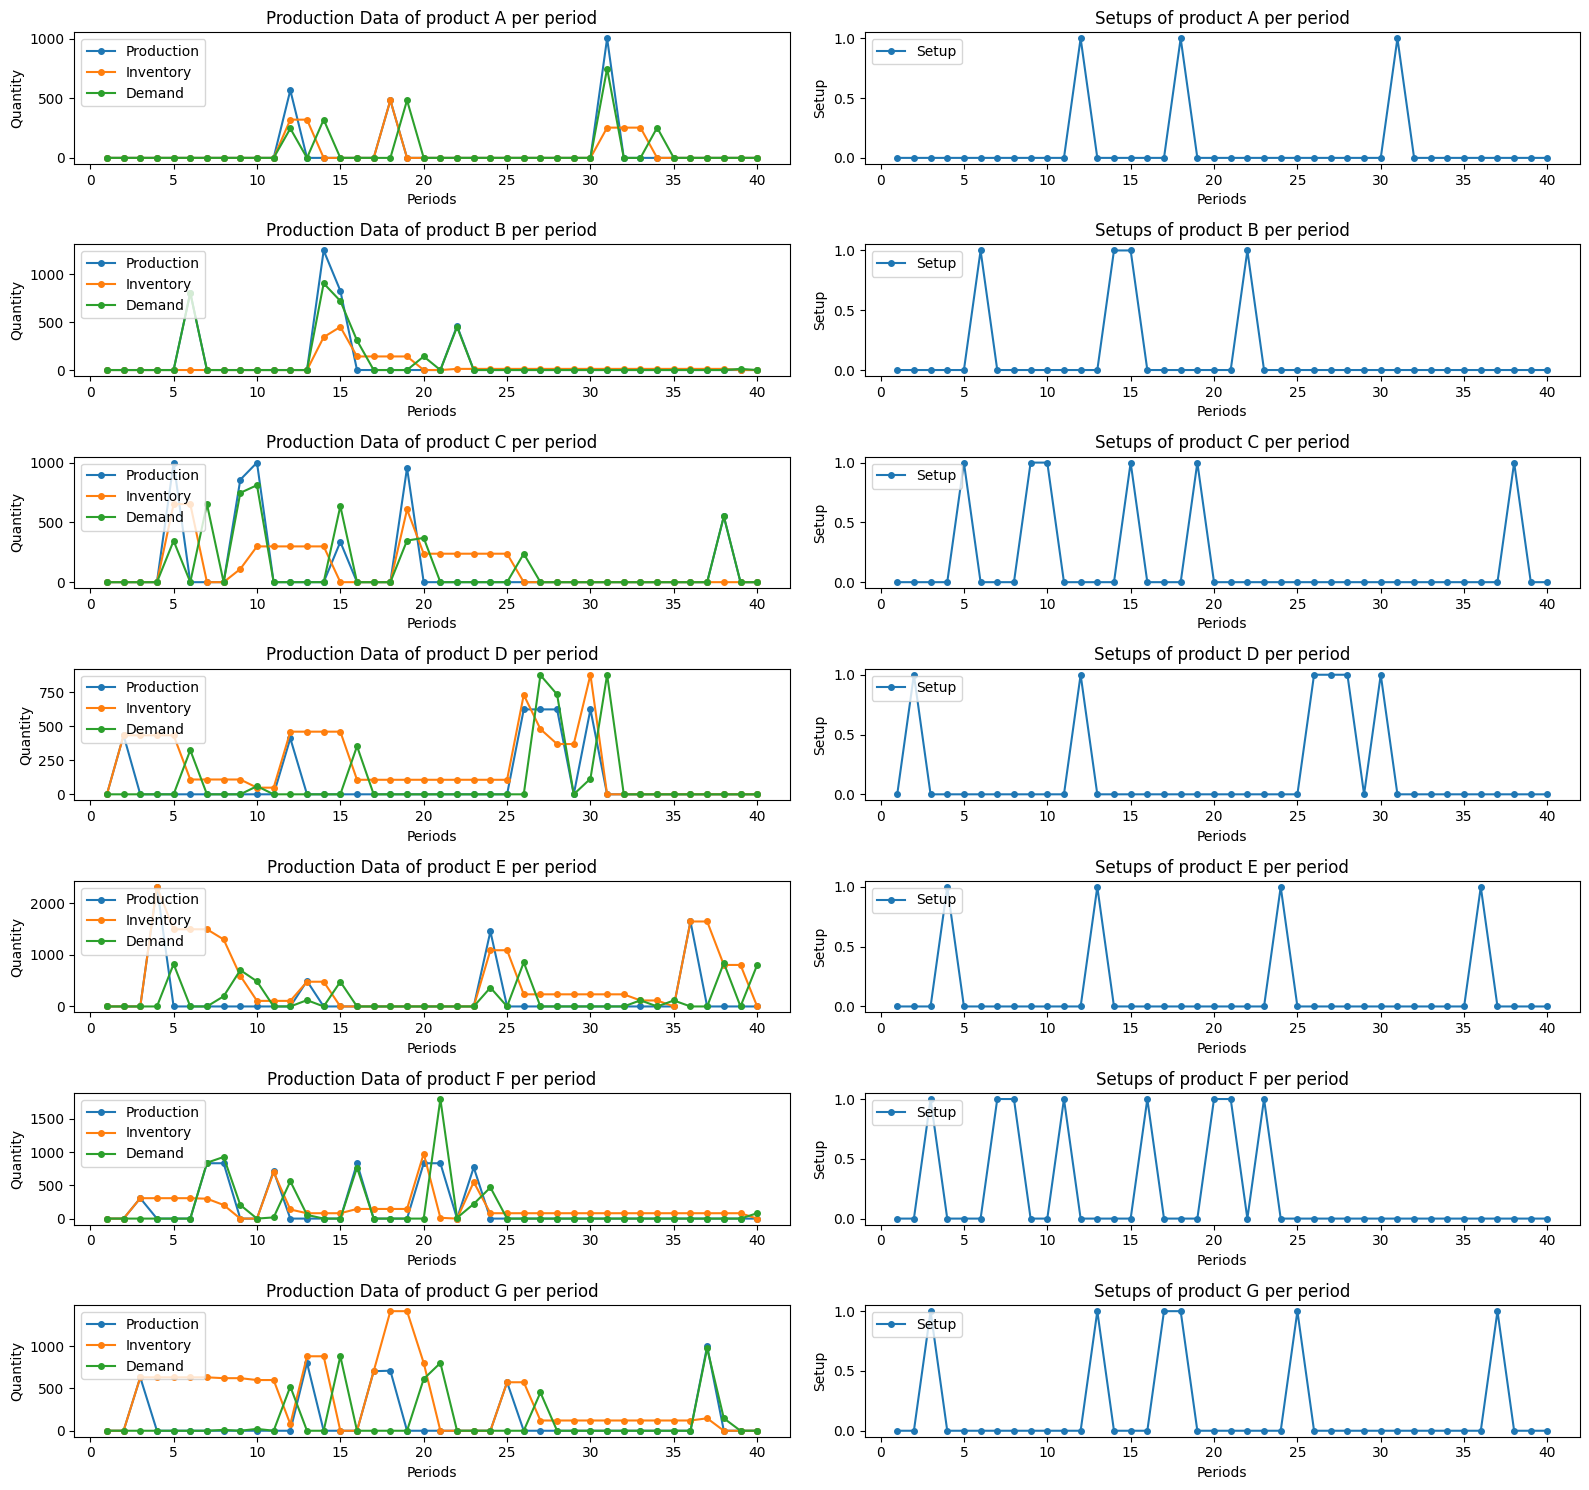

In [121]:
fig, ax = plt.subplots(nrows=len(products), ncols=2, figsize=(16,15))
for i in range(len(products)):
    
    ax[i,0].plot(periods, [X[products[i],t].solution_value for t in periods], marker='.', markersize=8, label='Production')
    ax[i,0].plot(periods, [L[products[i],t].solution_value for t in periods], marker='.', markersize=8, label='Inventory')
    ax[i,0].plot(periods, [demand.loc[products[i],t] for t in periods], marker='.', markersize=8, label='Demand')
    ax[i,0].legend(loc='upper left')

    ax[i,1].plot(periods, [G[products[i],t].solution_value for t in periods], marker='.', markersize=8, label='Setup')
    ax[i,1].legend(loc='upper left')

    ax[i,0].set_title(f'Production Data of product {products[i]} per period')
    ax[i,0].set_xlabel('Periods')
    ax[i,0].set_ylabel('Quantity')

    ax[i,1].set_title(f'Setups of product {products[i]} per period')
    ax[i,1].set_xlabel('Periods')
    ax[i,1].set_ylabel('Setup')

plt.tight_layout()

In [ ]:
overall_prodcution = np.sum()

Text(0, 0.5, 'Utilization in %')

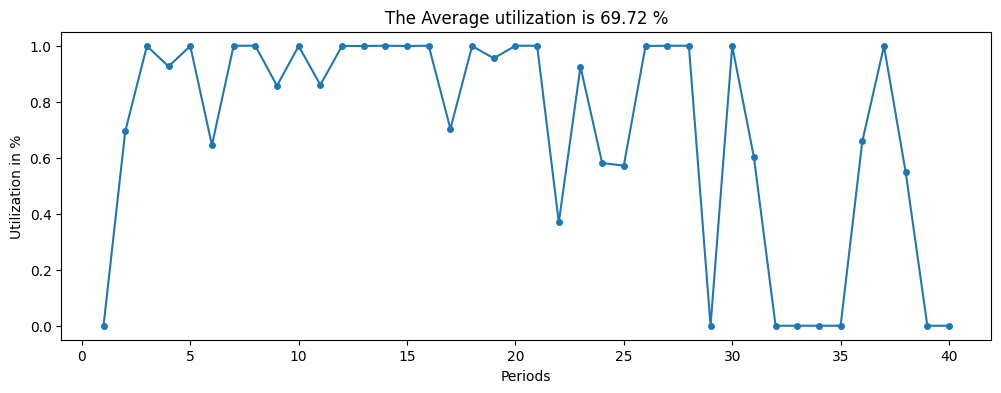

In [134]:
overall_production = []
for t in periods:
    overall_production.append(np.sum(np.fromiter((X[p,t].solution_value * input_data.loc[p, 'Production Time'] for p in products), int)))

fig, ax = plt.subplots(figsize=(12,4))
ax.plot(periods, [overall_production[i-1] / max_capacity for i in periods], marker='.', markersize=8, label='Utilization')

ax.set_title(f'The Average utilization is {round(np.average([overall_production[i-1] / max_capacity for i in periods]) * 100, 2)} %')
ax.set_xlabel('Periods')
ax.set_ylabel('Utilization in %')
